In [1]:
# import necessary modules
# numpy provides powerful multi-dimensional arrays to hold and manipulate data
import numpy as np
# matplotlib provides powerful functions for plotting figures
import matplotlib.pyplot as plt
# astropy provides unit system and constants for astronomical calculations
import astropy.units as u
import astropy.constants as const
# import Latex module so we can display the results with symbols
from IPython.display import Latex
%matplotlib inline

# import the CenterOfMass to determine the COM pos/vel of M33
from CenterOfMass2 import CenterOfMass
# import the GalaxyMass to determine the mass of M31 for each component
from GalaxyMass import ComponentMass
import random

In [105]:
class MWAnalyticOrbit:
    """ Calculate the analytical orbit of M33 around M31 """
    
    def __init__(self, filename):
        """ Initialize the class with the current properties of M33 
        input: filename, string denoting the name of the file in which the output orbit will be stored """
        
        # get the gravitational constant (the value is 4.498502151575286e-06)
        self.G = const.G.to(u.kpc**3/u.Msun/u.Gyr**2).value
        
        # store the output file name
        self.filename = filename
        
        # get the current pos/vel of MW relative to M31
        MW_COM = CenterOfMass("MW_000.txt", 2)
        self.r0 = MW_COM.COM_P(0.1, 2)  # equivalently could have set self.x self.y self.z to each component.
        self.v0 = MW_COM.COM_V(self.r0[0], self.r0[1],self.r0[2]).value
        self.r0 = self.r0.value
        
        M31_COM = CenterOfMass("M31_000.txt", 2)
        M31_r0 = M31_COM.COM_P(0.1, 2)
        ##### allowing the program to choose a random integer within the error space 
        # v_tan values taken from Van der Marel et al. (2019)
        vx_tan = random.randint(-2,70)
        vy_tan = random.randint(-148,-98)
        vz_tan = random.randint(-56,18)
        
        v_tan = np.array([vx_tan,vy_tan,vz_tan])
        
        print(np.sqrt(v_tan[0]**2+v_tan[1]**2+v_tan[2]**2),v_tan[0],v_tan[1],v_tan[2])
        
        M31_v0 = M31_COM.COM_V(M31_r0[0], M31_r0[1], M31_r0[2]).value + v_tan
        #print(M31_v0)
        self.r0 -= M31_r0.value #  subtract out the M31 COM Position from the previously defined values
        self.v0 -= M31_v0 
        # subtract out the M31 COM velocity from the previously defined values
        
        #### get the mass of each component in M31 and MW 
        # disk
        self.rdisk = 5.0 # set the scale length 
        self.Mdisk = ComponentMass("M31_000.txt", 2)*1e12
        self.MWdisk = ComponentMass('MW_000.txt',2)*1e12
        
        # bulge
        self.rbulge = 1.0 # set the bulge scale length
        self.Mbulge = ComponentMass("M31_000.txt", 3)*1e12
        self.MWbulge = ComponentMass('MW_000.txt',3)*1e12
        
        # Halo
        self.rhalo = 61.58 # use the Hernquist scale length (a) computed in HW5
        self.Mhalo = ComponentMass("M31_000.txt", 1)*1e12
        self.MWhalo = ComponentMass('MW_000.txt',1)*1e12
    
        ### ADD MW TOTAL MASS HERE #### 
        self.MWmass = self.MWdisk + self.MWbulge + self.MWhalo
    
        ### ADD M31 CIRCULAR SPEED HERE ### 
        self.Vc = -206 #km/s
        
        ### Fudge factor ## 
        self.fudge = 0.5
    
    
    def HenquistAccel(self, M, r_a, r):
        """ Compute the Hernquist profile acceleration 
        Inputs :  M the Hernquist mass (Msun)
                r_a the Hernquist scale length (kpc)
                r the position vector [ x, y, z]
        Returns:  the Acceleration vector for a Hernquist profile [Ax, Ay, Az]"""
        
        # follow the formula in the HW instructions
        r_mag = np.sqrt(np.sum(r**2))
        return -self.G * M / (r_mag * (r_a + r_mag)**2) * r
    
    def MiyamotoNagaiAccel(self, M, rd, r):
        """ Compute the Miyamoto-Nagai profile acceleration
        Inputs:  M  the disk mass (Msun)
                rd the disk scale length (kpc)
                r the position vector [ x, y, z]
        Returns: the Acceleration vector for a Miyamoto-Nagai profile [Ax, Ay, Az] """
        
        # follow the formula in the HW instructions
        R2 = np.sum(r[:2]**2)
        zd = rd / 5.0
        B = rd + np.sqrt(r[2]**2 + zd**2)
        return -self.G * M / (R2 + B**2)**1.5 * r * np.array([1, 1, B/(B-rd)]) 
        # the np.array allows for a different value for the z component of the acceleration
  

    ########### ADD Dynamical Friction Term Here ##################
    def DynamicalFriction(self,Msat,Vc,r,v):
        '''Function that computes dynamical friction on the satellite galaxy.
        INPUTS: Msat = Mass of satellite (in Msun); Vc = circular speed at large radii from M31.
        r = position vector of M33.
        v = veloctiy vector of M33.
        RETURNS: deceleration vector due to dynamical friction.
        a = 0.428 G Msat ln(lambda) /rmag^2 v/vmag'''
        rmag = np.sqrt(r[0]**2+r[1]**2+r[2]**2)
        vmag = np.sqrt(v[0]**2+v[1]**2+v[2]**2)
        # defining terms in Coulomb logarithm: ln(lambda)
        bmax = rmag
        bmin = self.G*Msat/Vc**2
        Coulomb = np.log(bmax/bmin)
        
        return -0.428*self.G*Msat*Coulomb/rmag**2*v/vmag*self.fudge
    
    
        
    ##### ADD v to M31Accel input #### 
    def M31Accel(self,r,v):
        """ Compute the total acceleration from M31
        Input: r the position vector [ x, y, z]
               v the velocity vector[vx,vy,vz]
        Returns: A vector for the total acceleration (halo+ bulge+ disk) [ Ax, Ay, Az]"""
        
        ###### ADD DYNAMICAL FRICTION HERE
        return self.HenquistAccel(self.Mhalo, self.rhalo, r) \
             + self.HenquistAccel(self.Mbulge, self.rbulge, r) \
             + self.MiyamotoNagaiAccel(self.Mdisk, self.rdisk, r) \
             + self.DynamicalFriction(self.MWmass,self.Vc,r,v)
    
    
    def LeapFrog(self, dt, r, v):
        """ perform one step Leap Frog integration for M33
        Input: dt time step in Gyr
            r the current position vector [ x, y, z] 
            v the currentvelocity vector [ vx, vy, vz]
        Returns:  Advances the position and velocity vectors by one timestep """
        
        # predict the position at the next half timestep
        rhalf = r + v * dt / 2.0
        
        # compute the velocity at the next timestep
        ##### ADD v to M31Accel ### 
        vnext = v + self.M31Accel(rhalf,v) * dt
        
        # compute the position at the next timestep
        rnext = r + (vnext+v)/2.0 * dt 
        
        return rnext, vnext
    ############### Developed RK-4 method as an alternative to Leap Frog ###################
    
    def RK4(self,h):
        '''Implementing the Range-Kutta 4 method to calculate the relative positions and velocities of M31 and MW.
        the two differential equations: dv = -G*M_31/r**2 and dr = v + a_M31*t
        INPUTS: the step size (h)
        RETURNS: the positions and velocities as a function of time.'''
        
        # definining the initial conditions:
        t = 0.0
        tmax = 10.0
        G = self.G
        M = self.Mdisk + self.Mbulge + self.Mhalo
        r = self.r0
        v = self.v0
        
        # defining the index and the arrays:
        i = 1
        R = np.zeros([int(tmax/h)+2,3])
        V = np.zeros([int(tmax/h)+2,3])
        R[0] = r[0],r[1],r[2]
        V[0] = v[0],v[1],v[2]
        Rmag = [np.linalg.norm(r)]
        Vmag = [np.linalg.norm(v)]
        
        while (t<tmax):
            dv = -1*G*M/r**2 
            dr = v + self.M31Accel(r,v)*t
            # calculating velocity at half time-step
            ft2 = t + h/2.0
            fr2 = r + (h/2.0)*dv
            fv2 = v + (h/2.0)*dr
            dv2 = -1*G*M/fr2**2
            
            # calculating distance at half time-step
            gt2 = t + h/2.0
            gr2 = r + h/2.0*dv
            gv2 = v + h/2.0*dr
            dr2 = gv2 + self.M31Accel(gr2,gv2)*t
            
            # calculating velocity at the second half time-step.
            ft3 = t+ h/2.0
            fr3 = r + h/2.0*dv2
            fv3 = v + h/2.0*dr2
            dv3 = -1*G*M/fr3**2
            
            # calculating distance at the second half time-step
            gt3 = t + h/2.0
            gr3 = r + h/2.0*dv2
            gv3 = v + h/2.0*dr2
            dr3 = gv3 + self.M31Accel(gr3,gv3)*t
            
            # calculating velocity at the full time step
            ft4 = t+h
            fr4 = r + h*dv3
            fv4 = v + h*dr3
            dv4 = -1*G*M/fr4**2
            
            # calculating postion at full time step
            gt4 = t+h
            gr4 = r + h*dv3
            gv4 = v + h*dr3
            dr4 = gv4 + self.M31Accel(gr4,gv4)*t
            
            t = t+h
            
            r = r + (h/6.0)*(dv+2*dv2+2*dv3+dv4)
            v = v + (h/6.0)*(dr+2*dr2+2*dr3+dr4)
            
            R[i] = (r[0],r[1],r[2])
            Rmag.append(np.sqrt(r[0]**2+r[1]**2+r[2]**2))
            
            V[i] = (v[0],v[1],v[2])
            Vmag.append(np.sqrt(v[0]**2+v[1]**2+v[2]**2))
            
            i += 1
            
        T = np.arange(0,tmax+(2*h),h)
        plt.plot(T,Rmag,'r',lw=3)
        plt.show()
        #return Rmag,Vmag
    
    
    def OrbitIntegration(self, t0, dt, tmax):
        """ Compute the orbit of M33 using the LeapFrog Scheme
        Input:  t0 the current time in Gyr
                dt the time step in Gyr
                tmax the final time in Gyr
        Returns: Generates a file with the original filename given when the class was initialized that stores
                the output of the orbit."""
        
        # initialize the time, counter, and the orbit array
        t = t0
        i = 1
        orbit = np.zeros([int(tmax/dt)+2, 7])
        
        orbit[0] = t0, *tuple(self.r0), *tuple(self.v0)
        
        # start the integration
        while (t < tmax):
            # move forward the time by one timestep
            t += dt
            orbit[i, 0] = t
            # integrate the position and velocity using the LeapFrog scheme
            orbit[i, 1:4], orbit[i, 4:] = \
                self.LeapFrog(dt, orbit[i-1, 1:4], orbit[i-1, 4:])
            
            i += 1 # update counter
        
        # write the data to a file
        np.savetxt(self.filename, orbit, fmt = "%11.3f"*7, comments='#', 
                   header="{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}"\
                   .format('t', 'x', 'y', 'z', 'vx', 'vy', 'vz'))
        

116.12493272333896 2 -116 5


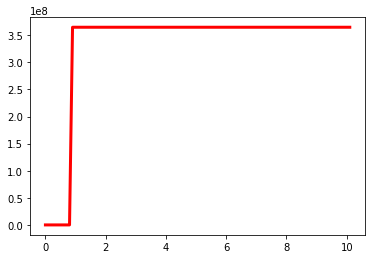

In [107]:
MW_RK4 = MWAnalyticOrbit("TestingRK4.txt")
MW_RK4.RK4(0.1)

In [27]:
MW = MWAnalyticOrbit("MWAnalyticOrbit.txt")
MW.OrbitIntegration(0, 0.1, 10.)

134.36145280548286 32 -127 -30


In [13]:
MW2 = MWAnalyticOrbit("MWAnalyticOrbit2.txt")
MW2.OrbitIntegration(0,0.1,10.)

149.42891286494725 52 -140 5


In [19]:
MW3 = MWAnalyticOrbit("MWAnalyticOrbit3.txt")
MW3.OrbitIntegration(0,0.1,10.)

121.55657119218195 54 -108 -14


In [33]:
MW4 = MWAnalyticOrbit("MWAnalyticOrbit4.txt")
MW4.OrbitIntegration(0,0.1,10.)

122.82507887235408 58 -101 -39


In [108]:
orbit_type = np.dtype([('t', 'f8'), ('r', 'f8', 3), ('v', 'f8', 3)])

# Read in Orbit of M33 relative to M31
MWOrbit = np.loadtxt("MWAnalyticOrbit.txt", dtype=orbit_type)
MWOrbit2 = np.loadtxt("MWAnalyticOrbit2.txt", dtype=orbit_type)
MWOrbit3 = np.loadtxt("MWAnalyticOrbit3.txt", dtype=orbit_type)
MWOrbit4 = np.loadtxt("MWAnalyticOrbit4.txt", dtype=orbit_type)


# Read in simulation Orbit from Homework 6
MWSimOrbit = np.genfromtxt('Orbit_MW.txt', dtype = orbit_type)
M31SimOrbit = np.genfromtxt('Orbit_M31.txt', dtype = orbit_type)

In [109]:
def relative_mag(orbit1, orbit2): # calculate relative sep or vel
    return np.sqrt(np.sum((orbit1['r'] - orbit2['r'])**2, axis=1)), \
           np.sqrt(np.sum((orbit1['v'] - orbit2['v'])**2, axis=1))
def vector_mag(orbit):
    return np.sqrt(np.sum(orbit['r']**2, axis=1)), \
           np.sqrt(np.sum(orbit['v']**2, axis=1))

In [110]:
# Determine the magnitude of the position and velocities 

# of MW and M31
M31_MW_R, M31_MW_V = vector_mag(MWOrbit)
M31_MW_R2, M31_MW_V2 = vector_mag(MWOrbit2)
M31_MW_R3, M31_MW_V3 = vector_mag(MWOrbit3)
M31_MW_R4, M31_MW_V4 = vector_mag(MWOrbit4)


# of MW and M31
M31_MW_SimR, M31_MW_SimV = relative_mag(M31SimOrbit, MWSimOrbit)

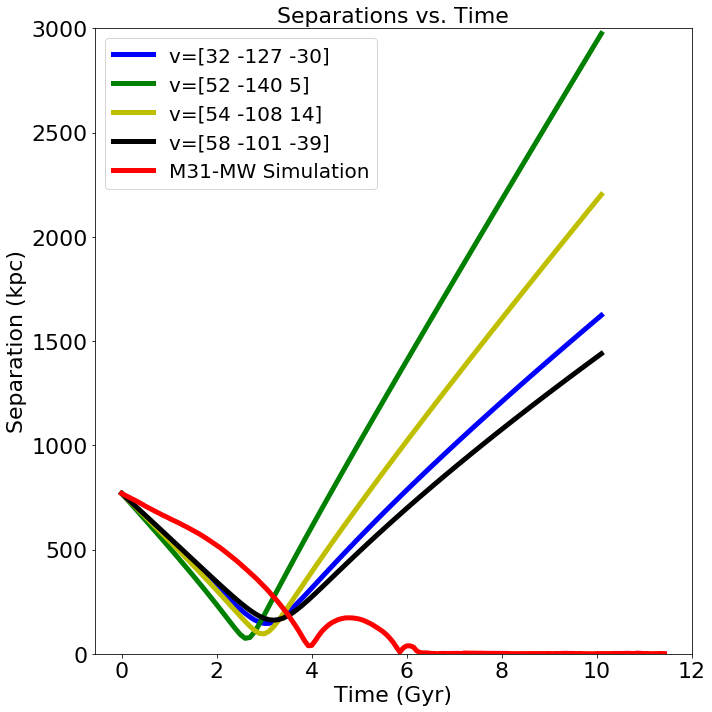

In [111]:
# Plot the orbital separations of the galaxies 
#################################

fig, ax= plt.subplots(figsize=(10, 10))

# Plot the analytical separation of M31 and M33
ax.plot(MWOrbit['t'], M31_MW_R, 'b', lw=5, label='v=[32 -127 -30]')
ax.plot(MWOrbit2['t'], M31_MW_R2, 'g', lw=5, label='v=[52 -140 5]')
ax.plot(MWOrbit3['t'], M31_MW_R3, 'y', lw=5, label='v=[54 -108 14]')
ax.plot(MWOrbit4['t'], M31_MW_R4, 'k', lw=5, label='v=[58 -101 -39]')
# Plot the simulated separation of M31 and M33
# Plot the simulated separation of M31 and M33
ax.plot(MWSimOrbit['t'], M31_MW_SimR, 'r', lw=5, label='M31-MW Simulation')



# Add axis labels
ax.set_xlabel('Time (Gyr)', fontsize=22)
ax.set_ylabel('Separation (kpc)', fontsize=22)
ax.set_title("Separations vs. Time", fontsize=22)

#adjust tick label font size
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)

# add a legend with some customizations.
legend = ax.legend(loc='upper left',fontsize=20)

plt.ylim(0, 3000)

# tight layout
fig.tight_layout()

# Save to a file
#fig.savefig('orbit_MW_R.pdf')

In [284]:
############### Sample RK-4 method for the following differential equations:
# x' = 2x + 4y
# y' = -x + 6y

def RK4(h,x0,y0):
    
    while (t<1.0):
        m1 = 2.0*x0 + 4.0*y0
        k1 = -x0 + 6.0*y0
        ft2 = t + h/2.0
        fx2 = x0 + (h/2.0)*m1
        fy2 = y0 + (h/2.0)*k1
        
        m2 = 2.0*fx2 + 4.0*fy2
        gt2 = t + h/2.0
        gx2 = x0 + h/2.0*m1
        gy2 = y0 + h/2.0*k1
        k2 = -1*gx2 + 6.0*gy2
        
        ft3 = t+h/2.0
        fx3 = x0 + h/2.0*m2
        fy3 = y0 + h/2.0*k2
        m3 = 2.0*fx3 + 4.0*fy3
        
        gt3 = t + h/2.0
        gx3 = x0 + h/2.0*m2
        gy3 = y0 +h/2.0*k2
        k3 = -1*gx3 + 6.0*gy3
        
        ft4 = t+h
        fx4 = x0 + h*m3
        fy4 = y0 + h*k3
        m4 = 2.0*fx4 + 4.0*fy4
        gt4 = t+h
        gx4 = x0+h*m3
        gy4 = y0+h*k3
        k4 = -1*gx4 + 6.0*gy4
        
        t = t+h
        
        x0 = x0 + (h/6.0)*(m1+2*m2+2*m3+m4)
        y0 = y0 + (h/6.0)*(k1+2*k2+2*k3+k4)
        
        print(t,x0,y0)
        
        
        
    
    